# Получение значений метрик

In [1]:
import sys
import json
import timeit
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython import display

from modelgym.report import Report
from modelgym.utils import XYCDataset
from modelgym.trainers import TpeTrainer
from modelgym.metrics import Accuracy, RocAuc, F1

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

sys.path.append('../../gmm_modules/')
from data_preparation import get_train_test_data
from metrics import metric_boxplot, eval_metrics, dump_metrics
from modelgym_models import XGBClassifier

np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.4 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


## Подготовим данные

In [2]:
%%time
path_to_dataset = '../../../datasets/HIGGS.csv.gz'
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
train_size = 400000
test_size = 100000

X_train, X_test, y_train, y_test = get_train_test_data(path_to_dataset, column_names, train_size, test_size)

CPU times: user 3min 20s, sys: 17.3 s, total: 3min 37s
Wall time: 3min 50s


In [3]:
# split X_train by class
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]  

In [4]:
X_good.shape, X_bad.shape, X_train.shape, X_test.shape

((200000, 28), (200000, 28), (400000, 28), (100000, 28))

## Подберем XGBoost с оптимальными параметрами

Создаем классификатор и trainer для подбора оптимальных параметров

In [5]:
models = [XGBClassifier]
trainer = TpeTrainer(models)

Обертка для данных

In [6]:
dataset = XYCDataset(X_train, y_train)

Сам подбор параметров

In [7]:
%%time
trainer.crossval_optimize_params(RocAuc(), dataset, metrics=[Accuracy(), RocAuc(), F1()], verbose=True,
                                 cv=3, opt_evals=20)

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 1.6576981560218025e-06, 'colsample_bylevel': 0.8266286588039223, 'colsample_bytree': 0.5213939752025252, 'eta': 0.2925426377149742, 'gamma': 0.0034412249156809214, 'lambdax': 0.006505492986185633, 'max_depth': 4, 'min_child_weight': 0.00046051818042811097, 'subsample': 0.9643372080606714}
Fitted
Run time: 79.00 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 1.6576981560218025e-06, 'colsample_bylevel': 0.8266286588039223, 'colsample_bytree': 0.5213939752025252, 'eta': 0.2925426377149742, 'gamma': 0.0034412249156809214, 'lambdax': 0.006505492986185633, 'max_depth': 4, 'min_child_weight': 0.00046051818042811097, 'subsample': 0.9643372080606714}
Fitted
Run time: 78.99 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 1.6576981560218025e-06, 'colsam

Fitted
Run time: 33.15 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 0.5266630532920237, 'colsample_bylevel': 0.8501088496025045, 'colsample_bytree': 0.5407911538722618, 'eta': 0.012200181880343818, 'gamma': 1.3173109709471447, 'lambdax': 0.06827159829356891, 'max_depth': 4, 'min_child_weight': 12.8515207605949, 'subsample': 0.7817895865743114}
Fitted
Run time: 31.01 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 4.7152128041955135e-06, 'colsample_bylevel': 0.9279900935906334, 'colsample_bytree': 0.9435719124280502, 'eta': 0.13224092228466736, 'gamma': 0.0008417313123282534, 'lambdax': 2.7790018751279317e-05, 'max_depth': 7, 'min_child_weight': 0.8111391845686768, 'subsample': 0.5105067612146056}
Fitted
Run time: 649.38 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha

Fitted
Run time: 293.30 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 1.6734180712199367, 'colsample_bylevel': 0.5591720939529441, 'colsample_bytree': 0.9713187137750563, 'eta': 0.021568840958935385, 'gamma': 1.6790803945216707e-05, 'lambdax': 0.0006856589442396446, 'max_depth': 6, 'min_child_weight': 1.5687261964906782e-07, 'subsample': 0.8588287679243385}
Fitted
Run time: 170.27 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 1.6734180712199367, 'colsample_bylevel': 0.5591720939529441, 'colsample_bytree': 0.9713187137750563, 'eta': 0.021568840958935385, 'gamma': 1.6790803945216707e-05, 'lambdax': 0.0006856589442396446, 'max_depth': 6, 'min_child_weight': 1.5687261964906782e-07, 'subsample': 0.8588287679243385}
Fitted
Run time: 183.17 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'sil

Fitted
Run time: 301.03 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 0.00016144829044243314, 'colsample_bylevel': 0.6415407007137599, 'colsample_bytree': 0.6260118276458179, 'eta': 0.2566057469527923, 'gamma': 0.13046781661805523, 'lambdax': 0.00024131160993218334, 'max_depth': 8, 'min_child_weight': 0.03868670859352842, 'subsample': 0.6787141304711013}
Fitted
Run time: 296.93 sec
*****************

*****************
{'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1, 'alpha': 0.00016144829044243314, 'colsample_bylevel': 0.6415407007137599, 'colsample_bytree': 0.6260118276458179, 'eta': 0.2566057469527923, 'gamma': 0.13046781661805523, 'lambdax': 0.00024131160993218334, 'max_depth': 8, 'min_child_weight': 0.03868670859352842, 'subsample': 0.6787141304711013}
Fitted
Run time: 302.32 sec
*****************

CPU times: user 2d 12h 9min 54s, sys: 9h 21min 37s, total: 2d 21h 31min 32s
Wall time: 

Результаты

In [8]:
reporter = Report(trainer.get_best_results(), dataset, [Accuracy(), RocAuc(), F1()])

In [9]:
reporter.print_all_metric_results()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
XGBClassifier  0.739445 (-0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
XGBClassifier  0.821695 (+0.00%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                           tuned
XGBClassifier  0.737856 (+0.00%)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



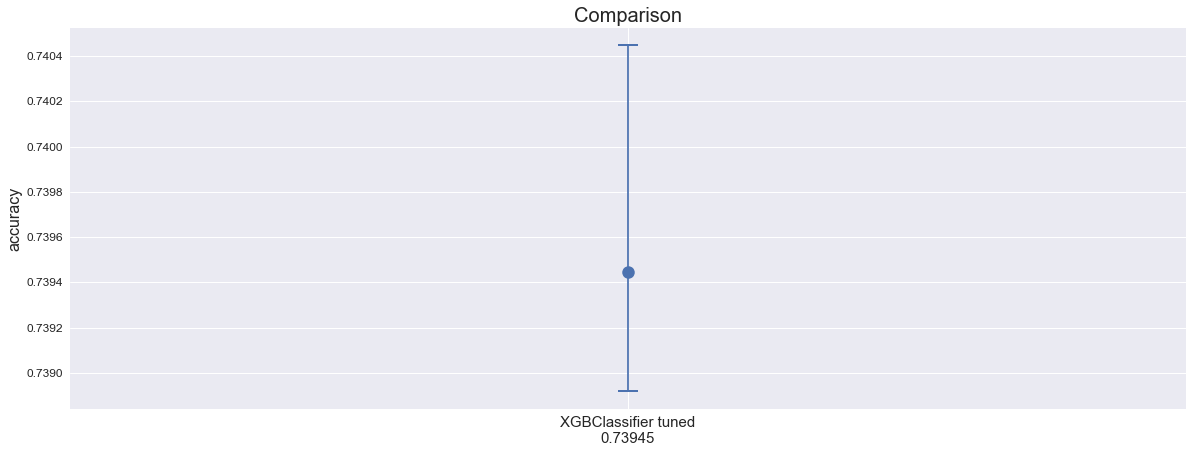


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



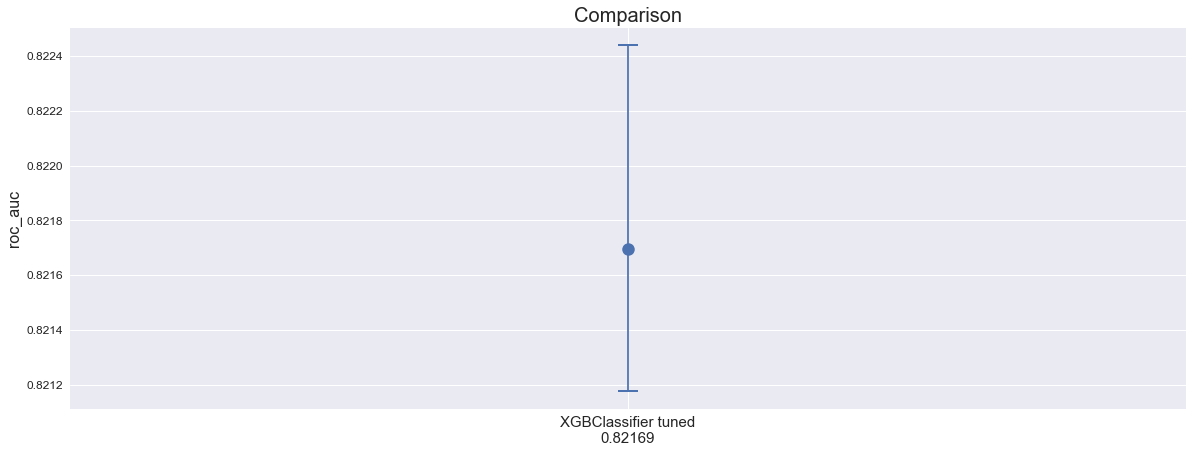


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    f1_score    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



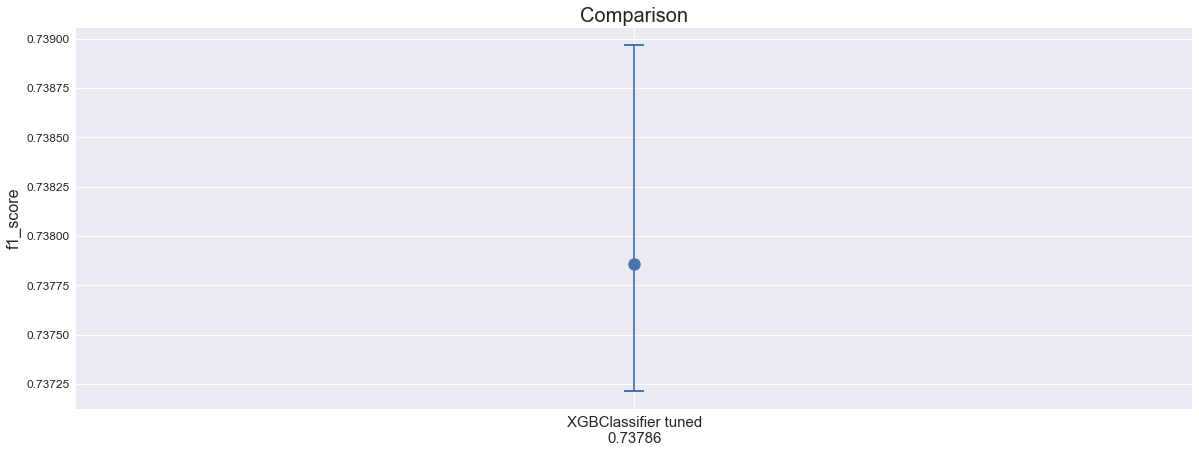

In [10]:
reporter.plot_all_metrics()

Вытащим значения оптимальных параметров

In [11]:
trainer_log = trainer.state['XGBClassifier']
opt_params = trainer_log.best_trial['result']['params']
opt_params

{'alpha': 3.86325458060099e-07,
 'colsample_bylevel': 0.6787933776552888,
 'colsample_bytree': 0.8772795295486776,
 'eta': 0.10568841636310605,
 'gamma': 2.3452327651158816e-07,
 'lambdax': 2.127295450298486,
 'max_depth': 7,
 'min_child_weight': 0.00019554323722355163,
 'n_estimators': 600,
 'subsample': 0.9066274853445584}

Сохраним эти значения

In [12]:
file_name = 'optimal_xgb_params.json'
with open(file_name, 'w', encoding="utf-8") as file:
    # writing
    json.dump(opt_params, file, indent=4, ensure_ascii=False)

Загрузим значения

In [13]:
file_name = 'optimal_xgb_params.json'
with open(file_name, 'r', encoding="utf-8") as file:
    opt_params = json.load(file)

In [14]:
opt_params

{'alpha': 3.86325458060099e-07,
 'colsample_bylevel': 0.6787933776552888,
 'colsample_bytree': 0.8772795295486776,
 'eta': 0.10568841636310605,
 'gamma': 2.3452327651158816e-07,
 'lambdax': 2.127295450298486,
 'max_depth': 7,
 'min_child_weight': 0.00019554323722355163,
 'n_estimators': 600,
 'subsample': 0.9066274853445584}

In [15]:
opt_params

{'alpha': 3.86325458060099e-07,
 'colsample_bylevel': 0.6787933776552888,
 'colsample_bytree': 0.8772795295486776,
 'eta': 0.10568841636310605,
 'gamma': 2.3452327651158816e-07,
 'lambdax': 2.127295450298486,
 'max_depth': 7,
 'min_child_weight': 0.00019554323722355163,
 'n_estimators': 600,
 'subsample': 0.9066274853445584}

## Получим значения метрик XGB при оптимальных параметрах

Выберем классификаторы

In [16]:
clf_name = "XGB_opt"
clf = xgb.XGBClassifier(**opt_params, nthread=-1, seed=111)
metrics_path = '../metrics/xgb_opt'

metrics_dict = {
    'pr_aucs' : {},
    'roc_aucs' : {},
    'p_at_r' : {
        '0.8': {},
        '0.9': {}, 
        '0.95': {},
        '0.99': {},
    }
}

Значения долей негативных примеров взял из Meeting minutes (29.03.2018)

In [ ]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([20, 20, 20, 20, 4, 4, 4, 4, 4])
n_evals_for_frac = np.zeros_like(fraction_of_negative_used)

Run time: 276.96 sec
PR_AUC:  (0.0001, 0.5937748237889285)
ROC_AUC:  (0.0001, 0.6052226766000001)
clf_name:  XGB_opt
n_evals_for_frac:  [16. 16. 15. 15.  4.  4.  4.  4.  4.]


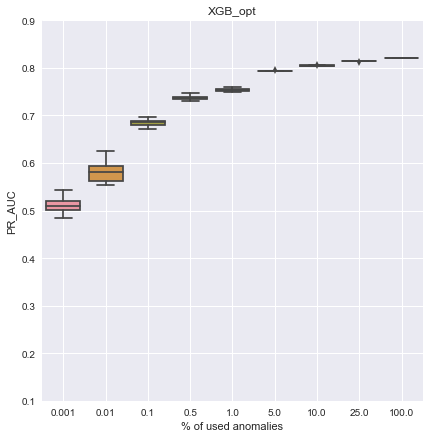

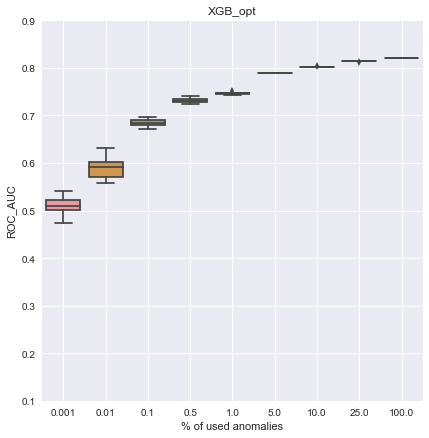

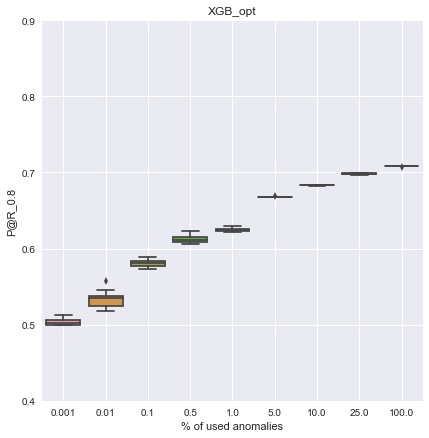

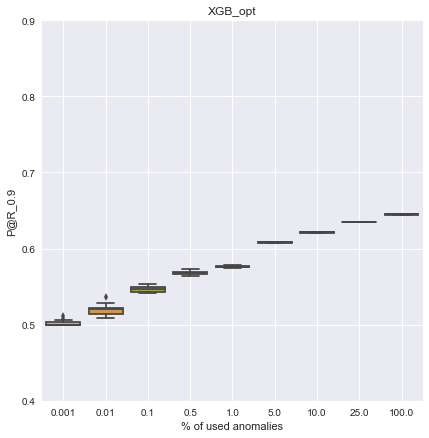

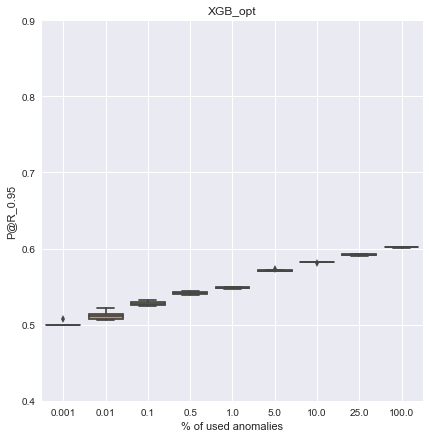

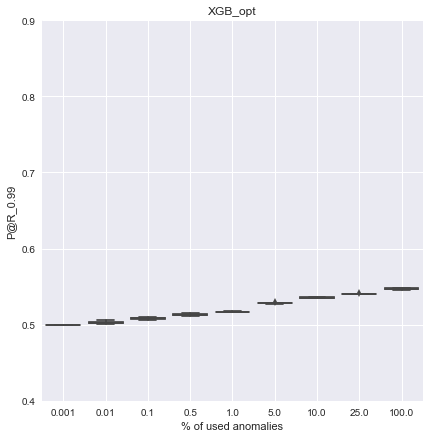

2it [07:06, 186.31s/it]

In [ ]:
%%time
while np.sum(n_resplits - n_evals_for_frac) > 0:
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if n_evals_for_frac[i] >= n_resplits[i]:
            continue
            
        # prepare data
        if frac > 1:
            end_ind = X_good.shape[0]
        else:   
            end_ind = int(X_good.shape[0] * frac)
            
        idx = np.random.permutation(X_bad.shape[0])

        # fit model and predict probas
        start_time = timeit.default_timer()
        clf.fit(np.concatenate((X_good, X_bad[idx[:end_ind]])), 
                np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel()) 
        y_pred = clf.predict_proba(X_test)[:, 1]
        run_time = timeit.default_timer() - start_time

        # eval and save metrics
        eval_metrics(y_test, y_pred, frac, metrics_dict, descr=clf_name)
        dump_metrics(metrics_path, metrics_dict)
        n_evals_for_frac[i] += 1

        # print info
        display.clear_output(wait=True)
        print("Run time: {:.2f} sec".format(run_time))
        print("PR_AUC: ", metrics_dict['pr_aucs'][clf_name][-1])
        print("ROC_AUC: ", metrics_dict['roc_aucs'][clf_name][-1])
        print('clf_name: ', clf_name)
        print('n_evals_for_frac: ', n_evals_for_frac)

        # plot metrics
        metric_boxplot(metrics_dict['pr_aucs'], ylabel='PR_AUC', ylim=(0.1, 0.9))
        plt.show()
        metric_boxplot(metrics_dict['roc_aucs'], ylabel='ROC_AUC', ylim=(0.1, 0.9))
        plt.show()
        for k in metrics_dict['p_at_r'].keys():
            metric_boxplot(metrics_dict['p_at_r'][k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
            plt.show()